In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *
from analysis.activations import make_dataset_df
from explain import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [4]:
universal_neuron_df = pd.read_csv(f'dataframes/interpretable_neurons/{model_name}/universal.csv')

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
vocab_df = pd.read_csv('dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

In [5]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

In [6]:
from analysis.activations import make_dataset_df
from analysis.vocab_df import create_normalized_vocab

dataset_df = make_dataset_df(ds, decoded_vocab)
decoded_norm_vocab, token_ix_2_normed_ix = create_normalized_vocab(vocab_df, decoded_vocab)

unigram_df = get_unigram_df(
    dataset_df, decoded_norm_vocab, token_ix_2_normed_ix)

In [7]:
dataset_df['normed_token'] = dataset_df['token'].apply(lambda x: token_ix_2_normed_ix[x])

In [8]:
context_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/sequence_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

token_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

prev_token_context_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/sequence_feature/layer_{l}/prev_token_variance_reduction.csv',
        dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)
prev_token_context_var_red_df = prev_token_context_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_context_var_red_df.columns})

prev_token_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/prev_token_variance_reduction.csv',
    dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

prev_token_var_red_df = prev_token_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_var_red_df.columns})

In [9]:
var_red_df = pd.concat([context_var_red_df, token_var_red_df, prev_token_context_var_red_df, prev_token_var_red_df], axis=1)


In [10]:
best_df = pd.concat([var_red_df.max(axis=1), var_red_df.idxmax(axis=1)], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'variance_reduction', 1: 'feature'})\
    .reset_index()

best_df['layer'] = best_df['neuron'].apply(lambda x: int(x.split('.')[0]))
best_df['neuron'] = best_df['neuron'].apply(lambda x: int(x.split('.')[1]))
best_df = best_df[['layer', 'neuron', 'variance_reduction', 'feature']]

In [11]:
best_syntax_df = best_df[best_df.feature.isin(context_var_red_df.columns)].head(50)

In [12]:
best_syntax_df.head(25)

,layer,neuron,variance_reduction,feature
110,1,3259,0.629095,is_spacy_neg
132,0,715,0.590726,is_past_tense
146,0,1951,0.576238,is_spacy_neg
175,3,2817,0.509809,is_inf_verb
181,13,3304,0.494908,is_perf_aspect
189,4,3623,0.477714,is_inf_verb
200,15,1184,0.469797,is_spacy_aux
201,12,3268,0.469307,is_plural
213,14,164,0.451691,is_perf_aspect
227,14,4012,0.425116,is_spacy_neg


In [13]:
syntax_neuron_data = best_syntax_df.head(25)[['layer', 'neuron', 'feature']].values

dataset_df = make_dataset_df(ds, decoded_vocab)

activation_df, neuron_cols = make_activation_df(
    dataset_df, 'cached_activations', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', -1, 
    syntax_neuron_data[:, :-1], use_post=False
)

In [14]:
#[x.replace('prev_', '').replace('_', ' ') for x in np.unique(prev_token_neuron_data[:, -1])]

In [15]:
syntax_neuron_data

array([[1, 3259, 'is_spacy_neg'],
       [0, 715, 'is_past_tense'],
       [0, 1951, 'is_spacy_neg'],
       [3, 2817, 'is_inf_verb'],
       [13, 3304, 'is_perf_aspect'],
       [4, 3623, 'is_inf_verb'],
       [15, 1184, 'is_spacy_aux'],
       [12, 3268, 'is_plural'],
       [14, 164, 'is_perf_aspect'],
       [14, 4012, 'is_spacy_neg'],
       [8, 455, 'is_plural'],
       [13, 1854, 'is_spacy_pron'],
       [12, 3230, 'is_spacy_neg'],
       [7, 1968, 'is_perf_aspect'],
       [18, 2157, 'is_spacy_aux'],
       [5, 983, 'is_inf_verb'],
       [21, 2932, 'is_spacy_aux'],
       [11, 3285, 'is_spacy_adv'],
       [7, 1044, 'is_plural'],
       [1, 2508, 'is_plural'],
       [17, 2608, 'is_spacy_neg'],
       [12, 3791, 'is_first_person'],
       [15, 1030, 'is_spacy_auxpass'],
       [2, 1274, 'is_spacy_neg'],
       [14, 3611, 'is_spacy_auxpass']], dtype=object)

In [16]:
display_names = {
    'is art pron': 'article',
    'is spacy adp': 'adposition',
    'is spacy aux': 'auxillary',
    'is spacy auxpass': 'auxillary passive',
    'is spacy cc': 'coordinating conjunction',
    'is spacy cconj': 'coordinating conjunction',
    'of unigram': '"of"',
    'the unigram': '"the"',
    'there unigram': '"there"',
    'to unigram': '"to"',
    'a unigram': '"a"',
    'contains comma': 'has comma',
    'in unigram': '"in"',
}


In [17]:
feature_df = pd.concat([vocab_df, unigram_df], axis=1)

save_path = os.path.join('dataframes', 'dataset_dfs', model_name, dataset_name)
context_feature_df = pd.read_pickle(os.path.join(save_path, 'dataset.p'))

In [26]:
best_syntax_df.head(25)

,layer,neuron,variance_reduction,feature
110,1,3259,0.629095,is_spacy_neg
132,0,715,0.590726,is_past_tense
146,0,1951,0.576238,is_spacy_neg
175,3,2817,0.509809,is_inf_verb
181,13,3304,0.494908,is_perf_aspect
189,4,3623,0.477714,is_inf_verb
200,15,1184,0.469797,is_spacy_aux
201,12,3268,0.469307,is_plural
213,14,164,0.451691,is_perf_aspect
227,14,4012,0.425116,is_spacy_neg


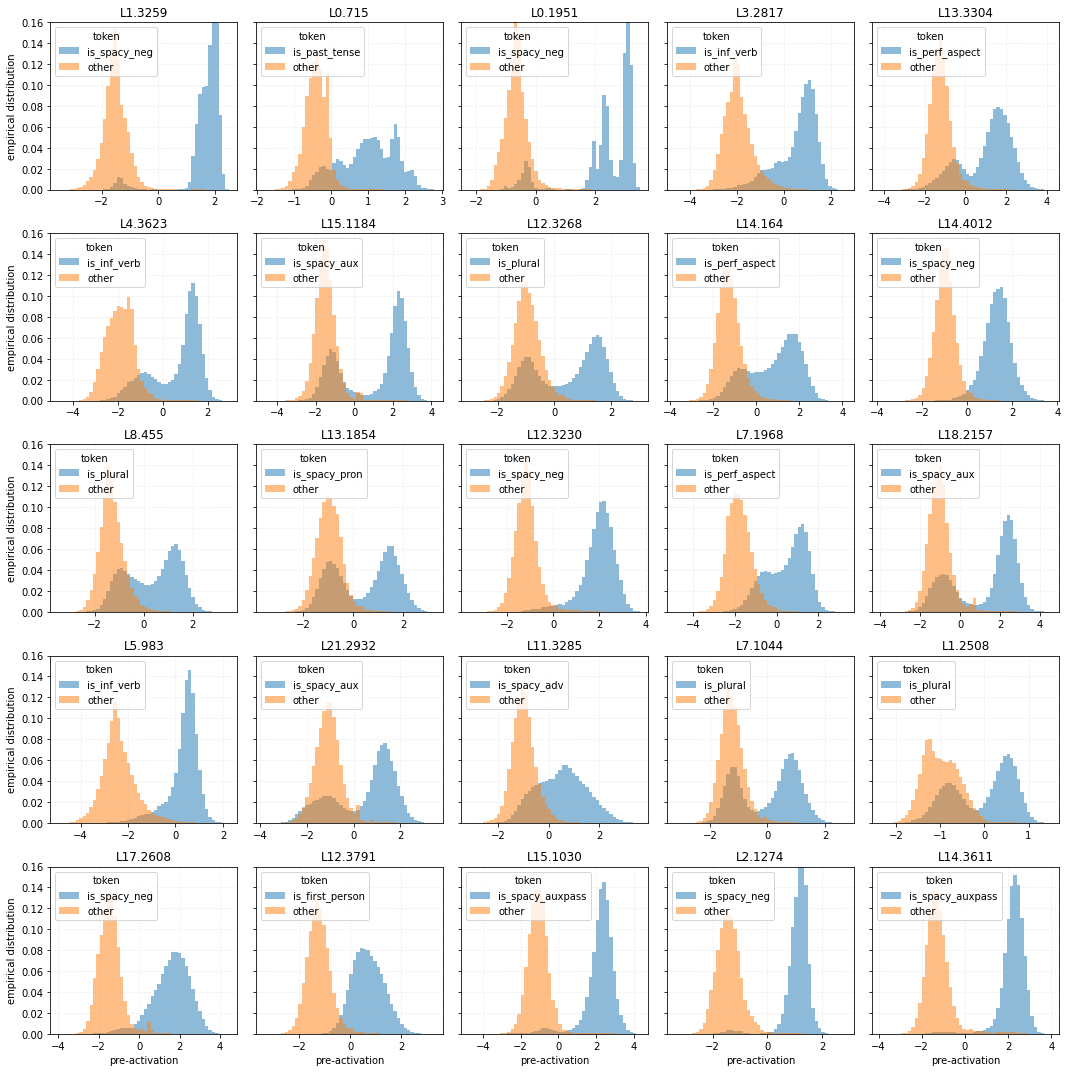

In [40]:
from analysis.plots import *

#syntax_neuron_data = syntax_neuron_data[:6]

n_cols = 5
n_rows = int(np.ceil(len(syntax_neuron_data) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharey=True)

ds_tokens = dataset_df.token.values

for ix, (layer, neuron, feature_name) in enumerate(syntax_neuron_data):

    ax = axs[ix // n_cols, ix % n_cols]
    ax.set_title(f'L{layer}.{neuron}')
    values = activation_df[f'{layer}.{neuron}']

    if feature_name in context_feature_df.columns:
        activation_df['feature'] = context_feature_df[feature_name].values
    elif feature_name in feature_df.columns:
        feature_tokens = feature_df[feature_df[feature_name]].index.values
        activation_df['feature'] = activation_df.token.isin(feature_tokens)
    else:
        raise ValueError(f'feature {feature_name} not found')

    classes = ~activation_df['feature'].values
    #class_labels = [display_names[feature_name.replace('_', ' ')], 'other']
    class_labels = [feature_name, 'other']
    
    token_histogram_by_class(
        values, classes, class_labels, ax=ax, 
        legend_loc='upper left', legend_title='token',
        #logy=True, plot_dist=False
    )

    if ix // n_cols == n_rows - 1:
        ax.set_xlabel('pre-activation')
    else:
        ax.set_xlabel('')
        
    if ix % n_cols == 0:
        ax.set_ylabel('empirical distribution')

    ax.set_ylim(top=0.16)

    ax.grid(alpha=0.2, linestyle='--')
    
plt.tight_layout()
# remove vertical space between axes
plt.subplots_adjust(wspace=0.1)

plt.savefig(f'figures/syntax_neurons.png', bbox_inches='tight', dpi=75)

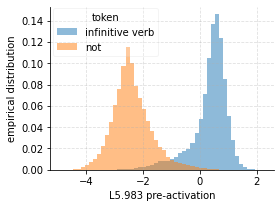

In [41]:
fig, ax = plt.subplots(figsize=(4, 3))

ds_tokens = dataset_df.token.values

layer = 5
neuron = 983
feature = 'is_inf_verb'
feature_name = feature

values = activation_df[f'{layer}.{neuron}']

if feature_name in context_feature_df.columns:
    activation_df['feature'] = context_feature_df[feature_name].values
elif feature_name in feature_df.columns:
    feature_tokens = feature_df[feature_df[feature_name]].index.values
    activation_df['feature'] = activation_df.token.isin(feature_tokens)
else:
    raise ValueError(f'feature {feature_name} not found')

classes = ~activation_df['feature'].values
class_labels = ['infinitive verb', 'not']

token_histogram_by_class(
    values, classes, class_labels, ax=ax,
    #logy=True, plot_dist=True
)

# turn off padding
ax.legend(loc='upper left', title='token', bbox_to_anchor=(-0.01, 1.02)).get_frame().set_alpha(0.2)

ax.set_xlabel(f'L{layer}.{neuron} pre-activation')

#ax.set_ylim(top=0.178)
ax.set_ylabel('empirical distribution')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.4, linestyle='--')

plt.savefig('figures/syntax_neuron_main.png', bbox_inches='tight', dpi=150)

In [19]:
activation_df['is_perf_aspect'] = context_feature_df['is_perf_aspect']
activation_df['is_inf_verb'] = context_feature_df['is_inf_verb']
activation_df['is_past_tense'] = context_feature_df['is_past_tense']

In [20]:
neuron = '3.2817'
feature = 'is_inf_verb'
base_cols = ['token', 'prev_token', 'subset', 'token_str', 'sequence_ix', 'position']
feature_df = activation_df[base_cols + [neuron, feature]]

In [21]:
def add_context(ds, df, decoded_vocab, prev_tokens=5):
    token_index = df[['sequence_ix', 'position']]
    token_tensor = ds['tokens']
    decoded_contexts = []
    for i, j in token_index.values:
        token_span = token_tensor[i, max(j - prev_tokens, 0):j+1].tolist()
        context_str = ''.join([decoded_vocab[t] for t in token_span])
        decoded_contexts.append(context_str)
    df['context'] = decoded_contexts
    return df
        
    

In [79]:
add_context(ds, feature_df.loc[feature_df[feature]].sort_values(neuron).head(50), decoded_vocab)

,token,prev_token,subset,token_str,sequence_ix,position,3.2817,is_inf_verb,context
1679640,25,32,stackexchange,:,3280,280,-3.544922,True,\nThanks\n\nA:
6115815,3653,10717,europarl,men,11944,487,-3.533203,True,t amendement te stemmen
4206005,1870,9199,github,And,8214,437,-3.427734,True,Object>> match = submitAnd
3495072,385,257,ubuntu_irc,us,6826,160,-3.419922,True,Ã¶rter aus
635698,385,257,openwebtext2,us,1241,306,-3.375000,True,igten Staaten aus
3876422,385,257,openwebtext2,us,7571,70,-3.328125,True,unseres Helden aus
4205578,1870,9199,github,And,8214,10,-3.324219,True,Object>> match = submitAnd
5201998,3653,10717,europarl,men,10160,78,-3.318359,True,kaar af te stemmen
7093032,14783,3758,github,iri,13853,296,-3.316406,True,uk membuat sendiri
7977480,385,257,ubuntu_irc,us,15581,8,-3.310547,True,solchen sachen aus


In [81]:
add_context(ds, feature_df.loc[~feature_df[feature]].sort_values(neuron, ascending=False).head(50), decoded_vocab)

,token,prev_token,subset,token_str,sequence_ix,position,3.2817,is_inf_verb,context
4305679,3128,1675,pile_cc,date,8409,271,2.046875,False,bog and springs. To date
1390701,3128,1675,openwebtext2,date,2716,109,2.031250,False,Aretha Franklin…. To date
7270391,3128,1675,pubmed_central,date,14199,503,1.977539,False,@b1]. To date
1764560,3128,2514,pubmed_central,date,3446,208,1.933594,False,\].\n\nTo date
3254392,3128,2514,openwebtext2,date,6356,120,1.885742,False,"ats!""\n\nTo date"
8326229,6167,284,pubmed_central,label,16262,85,1.883789,False,to a dataset subject to label
9072172,3128,1675,pubmed_central,date,17719,44,1.860352,False,15]\]. To date
3709702,3128,1675,wikipedia,date,7245,262,1.859375,False,College of Cardinals. To date
7311155,3128,1675,openwebtext2,date,14279,307,1.856445,False,chimeric molecules. To date
3347157,3128,1675,pile_cc,date,6537,213,1.853516,False,and swordsmanship. To date


In [80]:
#feature_df.groupby('token')[feature].mean().sort_values(ascending=False).loc[[550, 750, 4966]]
feature_df.groupby('token')[feature].mean().sort_values(ascending=False).loc[[1675]]

token
1675    0.000739
Name: is_inf_verb, dtype: float64